In [1]:
from PIL import Image
from matplotlib import pyplot as plt

## test with image

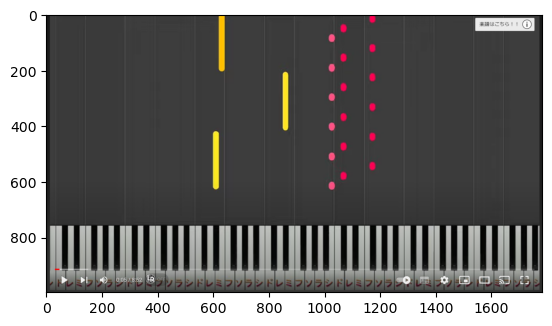

1784


In [7]:
img_path = r"C:\Users\qianq\OneDrive\画像\スクリーンショット\test.png"

img = Image.open(img_path)
plt.imshow(img)
plt.show()
width = img.size[0]
print(width)

In [18]:
# y=100の所の横一列の各ピクセル値が入っているリスト
pixels_value = []
for i in range(width):
    pixel = img.getpixel((i, 100))
    pixels_value.append(pixel)

## expand to video

In [2]:
import cv2
import time
import copy
import numpy as np

input_path = r"C:\Users\qianq\Videos\Captures\test3.mp4"
input_path_2 = r"C:\Users\qianq\Videos\Captures\【楽譜あり】カナタハルカ_『すずめの戸締まり』より（ピアノソロ中級～上級）RADWIMPS【ピアノアレンジ楽譜】 - YouTube - Google Chrome 2023-03-10 17-24-00.mp4"

In [ ]:
#このセルのコードは、キーボードの座標取得の為であり、関係ない

# importing the module
import cv2

# function to display the coordinates of
# of the points clicked on the image
def click_event(event, x, y, flags, params):

    # checking for left mouse clicks
	if event == cv2.EVENT_LBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print(x, ' ', y)

		# displaying the coordinates
		# on the image window
		font = cv2.FONT_HERSHEY_SIMPLEX
		cv2.putText(img, str(x) + ',' +
					str(y), (x,y), font,
					1, (255, 0, 0), 2)
		cv2.imshow('image', img)

	# checking for right mouse clicks	
	if event==cv2.EVENT_RBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print(x, ' ', y)

		# displaying the coordinates
		# on the image window
		font = cv2.FONT_HERSHEY_SIMPLEX
		b = img[y, x, 0]
		g = img[y, x, 1]
		r = img[y, x, 2]
		cv2.putText(img, str(b) + ',' +
					str(g) + ',' + str(r),
					(x,y), font, 1,
					(255, 255, 0), 2)
		cv2.imshow('image', img)

# driver function
if __name__=="__main__":

	# reading the image
    reader = cv2.VideoCapture(input_path_2)
    ret, img = reader.read()

	# displaying the image
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.imshow('image', img)

	# setting mouse handler for the image
	# and calling the click_event() function
    cv2.setMouseCallback('image', click_event)

	# wait for a key to be pressed to exit
    cv2.waitKey(0)

	# close the window
    cv2.destroyAllWindows()
    
    reader.release()


In [40]:
reader = cv2.VideoCapture(input_path)
fps = reader.get(cv2.CAP_PROP_FPS)
#各鍵盤の真ん中のx座標
keyboards = [904, 927, 958, 984, 1015, 1042, 1064, 1099, 1125, 1156, 1179, 1211] #テスト用、上で取得した座標を使用（手動で、鍵盤の真ん中のド～シの鍵盤の真ん中のピクセルの座標）
# previous_pvs = [(0, 0, 0, 0) for i in range(len(keyboards))] #previous_pixelsの初期化
# 各フレームのmidi
frame_midi = [(0, i, 0) for i in range(len(keyboards))] #テスト用。(time, sound(0~11), on/off)というタプルが12個ある
output_midi = [] #最終的に返すmidi
iteration = 0 #フレーム取得の繰り返し回数
frame_time = 0 #最初から数えた時の各フレームの経過時間
change_moment = [0 for i in range(len(keyboards))] #下と同じ
prev_change_moment = [0 for i in range(len(keyboards))] #とても短い間に２回急激な色変化が起きる場合に２回目を消す、という処理をするためのもの

while True:
    try:
        st = time.time()
        if iteration != 0:
            frame_time += 1/fps
        
        ret, frame = reader.read()
        if not ret:
            break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame)
        
        current_pvs = []
        
        for i in range(len(keyboards)):
            pv = pil_image.getpixel((keyboards[i], 200)) #get pixel values
            current_pvs.append(pv)
            if iteration == 0:
                previous_pvs = current_pvs #previous_pvsの初期化
            
        for i in range(len(keyboards)):
            difference = abs(current_pvs[i][0] - previous_pvs[i][0]) + abs(current_pvs[i][1] - previous_pvs[i][1]) + abs(current_pvs[i][2] - previous_pvs[i][2])
            if difference >= 100:
                change_moment[i] = frame_time
#                 print(change_moment[i], prev_change_moment[i])
#                 print(iteration)
                if change_moment[i] - prev_change_moment[i] > 0.1:
                    print(difference)
                    if frame_midi[i][2] == 0:
                        frame_midi[i] = (frame_time, i, 1)
                    else:
                        frame_midi[i] = (frame_time, i, 0)
                    output_midi.append(frame_midi[i])
        
        prev_change_moment = copy.copy(change_moment)
        previous_pvs = current_pvs
        iteration += 1
        
        elapsed_time = time.time() - st
        if elapsed_time < 1/fps:
            time.sleep(1/fps - elapsed_time)
            
    except KeyboardInterrupt:
        break
        
reader.release()

print(output_midi)

#はじめ、ピクセルRGB値の合計変化量の閾値を75にしたが、
#目視では色の変化が見当たらない時間帯にも、100~200位の色の変化が出る。（理由は不明）(憶測だが、バーの端っこの方だけ白→バーの色、みたいになってるのかも、細かすぎて人間の目では見えないが)
#よって、ピクセルRGB値の合計変化量の閾値を300に変更した

#上のやり方だと、動画によって都度閾値を変えないといけなく、非現実的なので、バーの端っこの色変化を避ける方法を変える
# とても短い時間の間で２回色の急激な変化があったら、２回目の方は消す。

[]


In [3]:
reader = cv2.VideoCapture(input_path_2)
fps = reader.get(cv2.CAP_PROP_FPS)
#各鍵盤の真ん中のx座標
keyboards = [10, 34, 62, 91, 122, 151, 176, 207, 235, 262, 293, 318, 344, 372, 398, 427, 455, 486, 511, 538, 568, 594, 622, 654, 676, 706, 732, 760, 790, 820, 847, 874, 903, 932, 960, 986, 1012, 1040, 1067, 1097, 1123, 1156, 1181, 1209, 1237, 1267, 1293, 1321, 1349, 1375, 1400, 1429, 1459, 1489, 1515, 1544, 1572, 1601, 1629, 1655, 1681, 1708, 1734, 1764, 1795, 1824, 1851, 1879, 1909, 1932, 1963, 1988, 2019, 2044, 2069, 2098, 2132, 2156]
# 各フレームのmidi
frame_midi = [(0, i, 0) for i in range(len(keyboards))] #テスト用。(time, sound(0~11), on/off)というタプルが12個ある
output_midi = [] #最終的に返すmidi
iteration = 0 #フレーム取得の繰り返し回数
frame_time = 0 #最初から数えた時の各フレームの経過時間
change_moment = [0 for i in range(len(keyboards))] #下と同じ
prev_change_moment = [0 for i in range(len(keyboards))] #とても短い間に２回急激な色変化が起きる場合に２回目を消す、という処理をするためのもの

while True:
    try:
        st = time.time()
        if iteration != 0:
            frame_time += 1/fps
        
        ret, frame = reader.read()
        if not ret:
            break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame)
        
        current_pvs = []
        
        for i in range(len(keyboards)):
            pv = pil_image.getpixel((keyboards[i], 150)) #get pixel values
            current_pvs.append(pv)
            if iteration == 0:
                previous_pvs = current_pvs #previous_pvsの初期化
            
        for i in range(len(keyboards)):
            difference = abs(current_pvs[i][0] - previous_pvs[i][0]) + abs(current_pvs[i][1] - previous_pvs[i][1]) + abs(current_pvs[i][2] - previous_pvs[i][2])
            if difference >= 100:
                change_moment[i] = frame_time
                if change_moment[i] - prev_change_moment[i] > 0.1:
                    print(difference)
#                     plt.imshow(frame)
#                     plt.show()
                    if frame_midi[i][2] == 0:
                        frame_midi[i] = (frame_time, i, 1)
                    else:
                        frame_midi[i] = (frame_time, i, 0)
                    output_midi.append(frame_midi[i])
        
        prev_change_moment = copy.copy(change_moment)
        previous_pvs = current_pvs
        iteration += 1
        
        elapsed_time = time.time() - st
        if elapsed_time < 1/fps:
            time.sleep(1/fps - elapsed_time)
            
    except KeyboardInterrupt:
        break
        
reader.release()

print(output_midi)

#はじめ、ピクセルRGB値の合計変化量の閾値を75にしたが、
#目視では色の変化が見当たらない時間帯にも、100~200位の色の変化が出る。（理由は不明）(憶測だが、バーの端っこの方だけ白→バーの色、みたいになってるのかも、細かすぎて人間の目では見えないが)
#よって、ピクセルRGB値の合計変化量の閾値を300に変更した

#上のやり方だと、動画によって都度閾値を変えないといけなく、非現実的なので、バーの端っこの色変化を避ける方法を変える
# とても短い時間の間で２回色の急激な変化があったら、２回目の方は消す。

# 残りの問題点
# timeが１秒ほどずれているが
# 精度はそこそこあると思うが、正確に確認できていない

335
310
231
114
144
362
236
284
146
264
316
117
266
456
256
463
225
467
118
129
202
139
510
321
415
345
152
403
528
125
242
108
416
221
415
336
114
349
147
543
105
195
169
483
106
144
354
140
418
198
154
488
190
443
338
319
335
466
324
469
269
114
337
213
148
458
338
514
354
158
318
334
166
501
265
489
252
299
198
144
212
272
484
230
118
474
536
107
127
462
430
287
148
468
333
306
111
322
506
252
164
471
146
468
116
134
109
172
430
240
325
305
472
139
296
312
470
114
451
[(2.6806746411483235, 55, 1), (2.6806746411483235, 67, 1), (2.7184306220095675, 66, 1), (2.8316985645932995, 0, 1), (5.9276889952153295, 0, 0), (7.664464114832573, 55, 0), (7.89100000000004, 66, 0), (7.928755980861284, 67, 0), (8.532851674641183, 60, 1), (8.7216315789474, 60, 0), (8.7216315789474, 62, 1), (8.759387559808644, 61, 1), (8.872655502392375, 62, 0), (8.910411483253618, 48, 1), (8.910411483253618, 64, 1), (9.325727272727297, 48, 0), (9.325727272727297, 64, 0), (9.627775119617246, 55, 1), (9.66553110047849, 54

In [10]:
print(len(keyboards))

78


In [4]:
import mido
import pretty_midi
import IPython.display

In [15]:
# Create a MIDI file
mid = mido.MidiFile()

# Create a track
track = mido.MidiTrack()
mid.tracks.append(track)

ticks_per_beat = 480
tempo = 1000000

# Loop through the list of tuples and create MidiMessage objects
for t in output_midi:
    # Get time, note and onoff from tuple
    time = t[0]
    note = t[1]
    onoff = t[2]

    # Check if onoff is 'on' or 'off'
    if onoff == 1:
        # Create a note_on message with velocity 64
        msg = mido.Message('note_on', note=note+33, velocity=64)
    elif onoff == 0:
        # Create a note_off message with velocity 0
        msg = mido.Message('note_off', note=note+33, velocity=0)
    
    # Set time attribute of msg to time
    time = int(mido.second2tick(time, ticks_per_beat, tempo))
    msg.time = time

    # Append msg to track
    track.append(msg)

#ここで失敗している。
# Save the MIDI file
mid.save("output.mid")

TypeError: save() got an unexpected keyword argument 'encoding'

In [11]:
pip install midi2audio

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Import the libraries
from midi2audio import FluidSynth
import IPython.display

# Convert the MIDI file to an audio file
fs = FluidSynth()
fs.midi_to_audio("output.mid", "output.wav")

# Play the audio file
IPython.display.Audio("output.wav")

FileNotFoundError: [WinError 2] The system cannot find the file specified